In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/MyDrive/data.zip"

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 617.0 kB/s eta 0:00:00


In [ ]:
import imghdr
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')



/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import shutil

shutil.rmtree("/content/256_ObjectCategories/257.clutter")

In [ ]:
##Load Data
data_dir = '/content/256_ObjectCategories'
# Get the list of image class names
all_image_classes = os.listdir(data_dir)




set(all_image_classes)

{'001.ak47',
 '002.american-flag',
 '003.backpack',
 '004.baseball-bat',
 '005.baseball-glove',
 '006.basketball-hoop',
 '007.bat',
 '008.bathtub',
 '009.bear',
 '010.beer-mug',
 '011.billiards',
 '012.binoculars',
 '013.birdbath',
 '014.blimp',
 '015.bonsai-101',
 '016.boom-box',
 '017.bowling-ball',
 '018.bowling-pin',
 '019.boxing-glove',
 '020.brain-101',
 '021.breadmaker',
 '022.buddha-101',
 '023.bulldozer',
 '024.butterfly',
 '025.cactus',
 '026.cake',
 '027.calculator',
 '028.camel',
 '029.cannon',
 '030.canoe',
 '031.car-tire',
 '032.cartman',
 '033.cd',
 '034.centipede',
 '035.cereal-box',
 '036.chandelier-101',
 '037.chess-board',
 '038.chimp',
 '039.chopsticks',
 '040.cockroach',
 '041.coffee-mug',
 '042.coffin',
 '043.coin',
 '044.comet',
 '045.computer-keyboard',
 '046.computer-monitor',
 '047.computer-mouse',
 '048.conch',
 '049.cormorant',
 '050.covered-wagon',
 '051.cowboy-hat',
 '052.crab-101',
 '053.desk-globe',
 '054.diamond-ring',
 '055.dice',
 '056.dog',
 '057.dol

# New section

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# Load the dataset
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    validation_split=0.01,
    subset="training"
)




Found 29780 files belonging to 256 classes.
Using 29483 files for training.


In [ ]:
##Convert the dataset to NumPy arrays
x = []
y = []
for image, label in data.as_numpy_iterator():
    x.append(image)
    y.append(label)

x = np.concatenate(x)
y = np.concatenate(y)

#Define the desired sample quantities
total_samples = x.shape[0]  # Total number of samples in the dataset
train_samples = 20300       # Number of samples for training
val_samples = 5800          # Number of samples for validation
test_samples = 2900         # Number of samples for testing

#Randomly shuffle the dataset
indices = np.arange(total_samples)
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

#Split the dataset into training, validation, and test sets
x_train = x[:train_samples]
y_train = y[:train_samples]

x_val = x[train_samples:train_samples + val_samples]
y_val = y[train_samples:train_samples + val_samples]

x_test = x[train_samples + val_samples:train_samples + val_samples + test_samples]
y_test = y[train_samples + val_samples:train_samples + val_samples + test_samples]

#Print the shapes of the resulting datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (20300, 128, 128, 3)
y_train shape: (20300,)
x_val shape: (5800, 128, 128, 3)
y_val shape: (5800,)
x_test shape: (2900, 128, 128, 3)
y_test shape: (2900,)


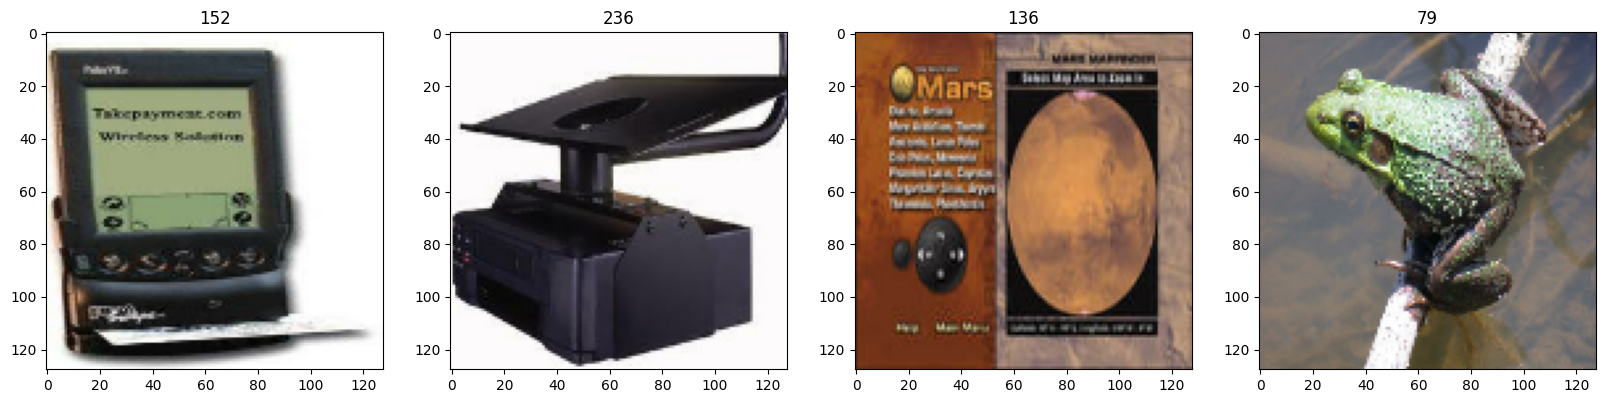

In [ ]:
import matplotlib.pyplot as plt
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
num_classes = 256
input_shape = (128, 128, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 200
image_size = 128  # We'll resize input images to this size
patch_size = 10  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 6
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
with tf.device('/CPU:0'):

    data_augmentation = keras.Sequential(
        [
            layers.Normalization(),
            layers.Resizing(image_size, image_size),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(
                height_factor=0.2, width_factor=0.2
            ),
        ],
        name="data_augmentation",
    )
    # Compute the mean and the variance of the training data for normalization.
    data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 10 X 10
Patches per image: 144
Elements per patch: 300


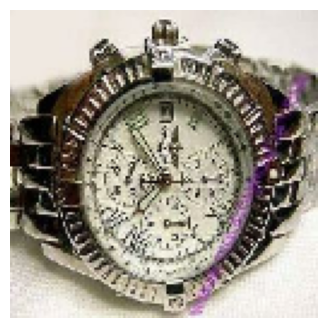

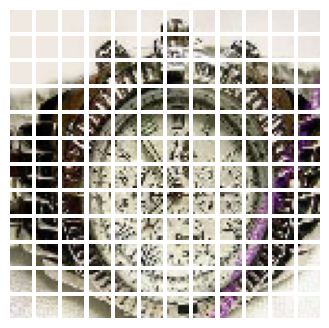

In [ ]:

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_val, y_val)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/200
318/318 [==============================] - 21s 38ms/step - loss: 5.6323 - accuracy: 0.0381 - top-5-accuracy: 0.0738 - val_loss: 5.2742 - val_accuracy: 0.0631 - val_top-5-accuracy: 0.1155
Epoch 2/200
318/318 [==============================] - 11s 34ms/step - loss: 5.3327 - accuracy: 0.0566 - top-5-accuracy: 0.1040 - val_loss: 5.0748 - val_accuracy: 0.0666 - val_top-5-accuracy: 0.1410
Epoch 3/200
318/318 [==============================] - 11s 34ms/step - loss: 5.1968 - accuracy: 0.0649 - top-5-accuracy: 0.1221 - val_loss: 4.9613 - val_accuracy: 0.0807 - val_top-5-accuracy: 0.1634
Epoch 4/200
318/318 [==============================] - 11s 33ms/step - loss: 5.1011 - accuracy: 0.0717 - top-5-accuracy: 0.1341 - val_loss: 4.9045 - val_accuracy: 0.0848 - val_top-5-accuracy: 0.1783
Epoch 5/200
318/318 [==============================] - 11s 34ms/step - loss: 5.0286 - accuracy: 0.0762 - top-5-accuracy: 0.1465 - val_loss: 4.8293 - val_accuracy: 0.1066 - val_top-5-accuracy: 0.2066
Epoch

In [ ]:
# Plotting the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
vit_classifier2 = create_vit_classifier()

In [ ]:
testdata = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)

In [ ]:
from time import time
import matplotlib.pyplot as plt


# Assuming you have already defined the vit_classifier model and loaded the x_val and y_val data

# Select the image you want to predict
image_index = 0  # Index of the image in x_val

image = x_val[0]  # Select the first image from x_val

# Expand dimensions if necessary
if len(image.shape) == 3:
    image = np.expand_dims(image, axis=0)

start = time()

# Make the prediction
predictions = vit_classifier.predict(image)
stop = time()
watch = stop - start
print(f"Time: {watch}")
print()
# Get the predicted class label
predicted_class = np.argmax(predictions)

# Print the predicted class label
print(f"Predicted class label: {predicted_class}")

